<a href="https://colab.research.google.com/github/pb2640/big_data_spring22/blob/parth-elk-transform/big_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
### Doing some basic installations

!pip install pyspark

In [3]:
!conda create -n sparknlp python=3.7 -y

/bin/bash: conda: command not found


In [4]:
 !pip install spark-nlp==3.4.4 pyspark==3.1.2 jupyter

     |████████████████████████████████| 145 kB 4.1 MB/s 
     |████████████████████████████████| 212.4 MB 68 kB/s 
     |████████████████████████████████| 198 kB 59.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=4c2d07c1a47e6abfb67301ce26da6091cb8e9496bb8a85ea4a635844654bdf30
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [65]:
#mounting my gdrive so that I can use the files directly (uploading thru upload is super slow.)
from google.colab import drive

drive.mount("/content/drive/")


Mounted at /content/drive/


In [68]:
news_df.show(5)

+----------+--------------------+-------+--------+--------------------+--------------------+-------+------------------+--------------------+
|      Date|               Title|    Lat|     Lon|            Location|            GeoCoord|GeoType|           DocTone|      ContextualText|
+----------+--------------------+-------+--------+--------------------+--------------------+-------+------------------+--------------------+
|2020-01-22|S & P 500 , Nasda...|40.7068|-74.0113|New York Stock Ex...|POINT(-74.0113 40...|      3| -1.96078431372549|reuters the s p 5...|
|2020-03-25|Some local leader...|44.2795|-73.9799|Lake Placid, New ...|POINT(-73.9799 44...|      3|-0.411522633744856|this current emer...|
|2020-03-10|Coronavirus clust...|42.1497|-74.9384|New York, United ...|POINT(-74.9384 42...|      2| -3.69668246445498|down large events...|
|2020-03-10|The Latest : Slov...|40.9115|-73.7824|New Rochelle, New...|POINT(-73.7824 40...|      3| -3.21167883211679|guard troops will...|
|2020-03-10|V

In [67]:
path = "/content/drive/MyDrive/data/sample_data.csv"
news_df = spark.read.csv(path, header=True)


In [69]:
### Total new articles 
news_df.count()

300000

In [99]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

from pyspark.sql.functions import from_unixtime, to_date, year, udf, explode, split, col, length, rank, dense_rank, avg, sum,month
from pyspark.sql.window import Window

In [73]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment", sentiment)
news_sentiment = news_df.withColumn("Sentiment",sentiment('ContextualText').cast('double'))

In [74]:
news_sentiment.show(5)

+----------+--------------------+-------+--------+--------------------+--------------------+-------+------------------+--------------------+--------------------+
|      Date|               Title|    Lat|     Lon|            Location|            GeoCoord|GeoType|           DocTone|      ContextualText|           Sentiment|
+----------+--------------------+-------+--------+--------------------+--------------------+-------+------------------+--------------------+--------------------+
|2020-01-22|S & P 500 , Nasda...|40.7068|-74.0113|New York Stock Ex...|POINT(-74.0113 40...|      3| -1.96078431372549|reuters the s p 5...| 0.18896103896103894|
|2020-03-25|Some local leader...|44.2795|-73.9799|Lake Placid, New ...|POINT(-73.9799 44...|      3|-0.411522633744856|this current emer...|-0.05040792540792...|
|2020-03-10|Coronavirus clust...|42.1497|-74.9384|New York, United ...|POINT(-74.9384 42...|      2| -3.69668246445498|down large events...|  0.1337617243867244|
|2020-03-10|The Latest : Slo

In [77]:
ordered_sentiment = news_sentiment.orderBy(["Sentiment"]).show(5)

+----------+--------------------+-------+--------+--------------------+--------------------+-------+-----------------+--------------------+-------------------+
|      Date|               Title|    Lat|     Lon|            Location|            GeoCoord|GeoType|          DocTone|      ContextualText|          Sentiment|
+----------+--------------------+-------+--------+--------------------+--------------------+-------+-----------------+--------------------+-------------------+
|2020-04-13|  OrlyTaitzEsq . com|42.1497|-74.9384|New York, United ...|POINT(-74.9384 42...|      2|              0.0|york gov andrew c...|               -1.0|
|2020-04-26|NY inmates ramp u...| 42.919|-76.7263|Cayuga, New York,...|POINT(-76.7263 42...|      3|-4.20792079207921|haven correctiona...|               -1.0|
|2020-04-12|BBC World Service...|42.1497|-74.9384|New York, United ...|POINT(-74.9384 42...|      2|-13.8888888888889|governor of the w...|-0.6212121212121212|
|2020-04-01|National coronavi...| 40.809

In [81]:
news_sentiment.select('ContextualText').take(1)

[Row(ContextualText='reuters the s p 500 and the nasdaq were set for record highs on wednesday as investors took heart from china efforts to contain a virus outbreak and a strong forecast from ibm traders work on the floor at the new york stock exchange nyse in new york u s january 21 2020 reuters brendan mcdermid the main indexes retreated from record highs on tuesday after officials confirmed the first u s case of the coronavirus that has killed nine and infected 440 in china while the death toll has risen to nine it feels like affirmation were getting out of china is stemming fears that this is turning into an epidemic said art hogan')]

In [84]:
ordered_sentiment = news_sentiment.orderBy(["Sentiment"])

In [86]:
ordered_sentiment.select('ContextualText','Sentiment').take(10)

[Row(ContextualText='haven correctional facility in dutchess county were making 200 to 250 coffins a week now state prisoners are making about 1 400 coffins a week the work has expanded to auburn correctional facility which is now making about 200 coffins a week state officials say the auburn correctional facility in cayuga county photo michael greenlar of syracuse com via tns the auburn correctional facility in cayuga county photo michael greenlar of syracuse com via tns that grim count is part of the state efforts to use incarcerated people as part of the response to covid 19 prisoners are also making masks and', Sentiment=-1.0),
 Row(ContextualText='york gov andrew cuomo said that the state is controlling the spread of the coronavirus and it appears that the worst is over if we continue to be', Sentiment=-1.0),
 Row(ContextualText='governor of the worst affected state new york said the death rate there is stabilising but at a horrific level also there are concerns in sweden about it

In [89]:
import datetime
news_df.select(
    year("Date").alias('year')).show()

+----+
|year|
+----+
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
|2020|
+----+
only showing top 20 rows



In [95]:
sentiment_df = news_sentiment.withColumn("Year", year("Date"))

In [100]:
sentiment_df = sentiment_df.withColumn("Month", month("Date"))

In [102]:
year_sentiment = sentiment_df.groupBy("Month").sum("Sentiment")

In [103]:
pandasDF = year_sentiment.toPandas()
print(pandasDF)

   Month  sum(Sentiment)
0      1      176.764484
1      3    11727.952807
2      5     2988.940583
3      4    11429.175197
4      2      485.607043


In [107]:
year_sentiment.select("Month").show()

+-----+
|Month|
+-----+
|    1|
|    3|
|    5|
|    4|
|    2|
+-----+



In [105]:
pandasDF.head(10)

,Month,sum(Sentiment)
0,1,176.764484
1,3,11727.952807
2,5,2988.940583
3,4,11429.175197
4,2,485.607043


In [104]:
import seaborn as sns

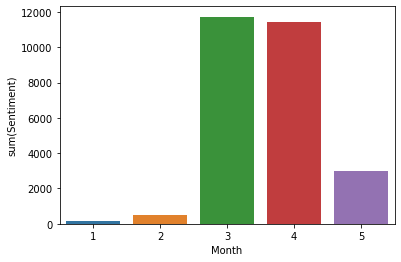

In [110]:
sns.barplot(data=pandasDF, x="Month", y="sum(Sentiment)")

In [ ]:
news.groupBy("Date").sum("Sentiment").show(truncate=False)

In [75]:
# data = spark.createDataFrame([['Part this living in New York.This is sentence two. sentence 3']]).toDF('text')

In [ ]:
data = []

In [10]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

In [30]:
spark = sparknlp.start()

In [43]:
data = spark.createDataFrame([['Parth is livingy in New York.This is senteeence two. sentence 3']]).toDF('text')

In [44]:
document =  DocumentAssembler().setInputCol('text').setOutputCol('document').setCleanupMode('shrink')

In [45]:
sentence = SentenceDetector().setInputCols('document').setOutputCol('sentence')

In [46]:
#always use sentence detector over document
sentence.setExplodeSentences(True)

SentenceDetector_1f2ab7814791

In [47]:
tokenizer = Tokenizer().setInputCols("sentence").setOutputCol('token')

In [48]:
tokenizer.setExceptions(['e-mail'])

Tokenizer_8d8b041f2707

In [49]:
checker = NorvigSweetingModel.pretrained().setInputCols(["token"]).setOutputCol('checked')

spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]


In [50]:
embeddings = WordEmbeddingsModel.pretrained().setInputCols(['sentence','checked']).setOutputCol('embeddings')

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [51]:
ner = NerDLModel.pretrained().setInputCols(["sentence","checked","embeddings"]).setOutputCol('ner')

ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [52]:
converter = NerConverter().setInputCols(['sentence','checked','ner']).setOutputCol('chunk')

In [53]:

from pyspark.ml import Pipeline

In [54]:
pipeline = Pipeline().setStages([document,sentence,tokenizer,checker,embeddings,ner,converter])

In [55]:
#required by protocol even if stages are trained already
model = pipeline.fit(data)

In [56]:
result = model.transform(data)

In [57]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|             checked|          embeddings|                 ner|               chunk|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Parth is livingy ...|[{document, 0, 62...|[{document, 0, 51...|[{token, 0, 4, Pa...|[{token, 0, 4, Pa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 20, 32, ...|
|Parth is livingy ...|[{document, 0, 62...|[{document, 53, 6...|[{token, 53, 60, ...|[{token, 53, 60, ...|[{word_embeddings...|[{named_entity, 5...|                  []|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--

In [58]:
result.select('sentence.result').show(truncate = False)

+------------------------------------------------------+
|result                                                |
+------------------------------------------------------+
|[Parth is livingy in New York.This is senteeence two.]|
|[sentence 3]                                          |
+------------------------------------------------------+



In [59]:
result.select('checked.result').show(truncate = False)

+--------------------------------------------------------------+
|result                                                        |
+--------------------------------------------------------------+
|[Party, is, livings, in, New, York.This, is, sentence, two, .]|
|[sentence, 3]                                                 |
+--------------------------------------------------------------+



In [60]:
result.select('ner.result').show(truncate = False)

+--------------------------------------+
|result                                |
+--------------------------------------+
|[O, O, O, O, B-LOC, I-LOC, O, O, O, O]|
|[O, O]                                |
+--------------------------------------+



In [61]:
result.select('chunk.result','chunk.begin','chunk.end').show(truncate = False)

+---------------+-----+----+
|result         |begin|end |
+---------------+-----+----+
|[New York.This]|[20] |[32]|
|[]             |[]   |[]  |
+---------------+-----+----+



In [ ]:
## we can also create LightPipelines which are faster as these do not have spark overheads